In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raihanahmad","key":"ae19ba2f01fb80464fe934c610cb44dd"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv kaggle.json /root/.kaggle/

# Set permission agar file bisa dibaca
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aastha2807/image-deblurring

Dataset URL: https://www.kaggle.com/datasets/aastha2807/image-deblurring
License(s): unknown
image-deblurring.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile

# Menentukan lokasi file zip yang diunduh
zip_file = '/content/image-deblurring.zip'

# Ekstrak file zip ke direktori yang sesuai
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/image_deblurring/')

In [ ]:
!pip install tensorflow numpy matplotlib opencv-python

In [ ]:
!pip install opencv-python

In [ ]:

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.utils import Sequence

In [ ]:

dataset_path = '/content/image_deblurring'
image_size = (256, 256)
batch_size = 16
epochs = 50

In [ ]:

def load_image(image_path, image_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    img = img / 255.0  # Normalisasi
    return img

In [ ]:

class DeblurDataGenerator(Sequence):
    def __init__(self, blur_folder, sharp_folder, batch_size=16, image_size=(256, 256), shuffle=True):
        self.blur_folder = blur_folder
        self.sharp_folder = sharp_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.filenames = os.listdir(blur_folder)
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_files = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]
        blurred_images = []
        sharp_images = []

        for filename in batch_files:
            blur_path = os.path.join(self.blur_folder, filename)
            sharp_path = os.path.join(self.sharp_folder, filename)

            blur_img = load_image(blur_path, self.image_size)
            sharp_img = load_image(sharp_path, self.image_size)

            blurred_images.append(blur_img)
            sharp_images.append(sharp_img)

        return np.array(blurred_images), np.array(sharp_images)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(256, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # ================= Encoder =================
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # ================= Bottleneck =================
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)

    # ================= Decoder =================
    u5 = layers.UpSampling2D((2, 2))(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(3, (1, 1), activation='sigmoid')(c7)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model


In [ ]:
# =====================[ 6. Inisialisasi Generator ]=====================
train_gen = DeblurDataGenerator(
    os.path.join(dataset_path, 'train/blur'),
    os.path.join(dataset_path, 'train/sharp'),
    batch_size=batch_size,
    image_size=image_size
)

val_gen = DeblurDataGenerator(
    os.path.join(dataset_path, 'validation/blur'),
    os.path.join(dataset_path, 'validation/sharp'),
    batch_size=batch_size,
    image_size=image_size
)

In [ ]:
# =====================[ 7. Build dan Tampilkan Model ]=====================
model = build_model(input_shape=(256, 256, 3))
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 32, 32, 128)    │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_9 (UpSampling2D)  │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 64, 64, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 128, 128, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 256, 256, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 758,979 (2.90 MB)

 Trainable params: 758,979 (2.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# =====================[ 8. Training Model ]=====================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs
)

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - loss: 0.0321 - val_loss: 0.0098
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 220ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 230ms/step - loss: 0.0085 - val_loss: 0.0075
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 223ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - loss: 0.0075 - val_loss: 0.0067
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 226ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 70s 222ms/step - loss: 0.0068 - val_loss: 0.0070
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 69s 222ms/step - loss: 0.0071 - val_loss: 0.0062
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 72s 231ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 10/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 227ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 11/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 87s 243ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 12/50
312/312

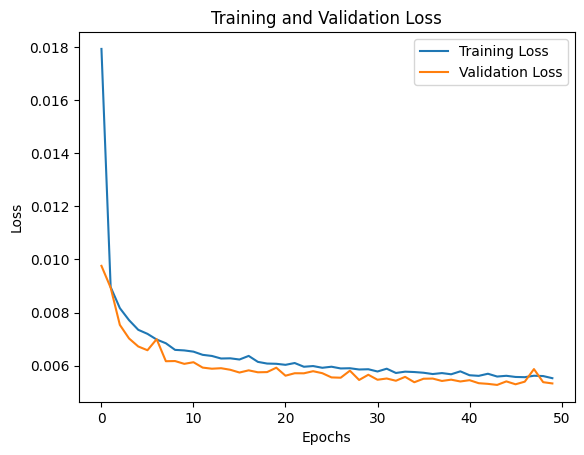

In [ ]:
# =====================[ 9. Plot Loss Training & Validation ]=====================
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


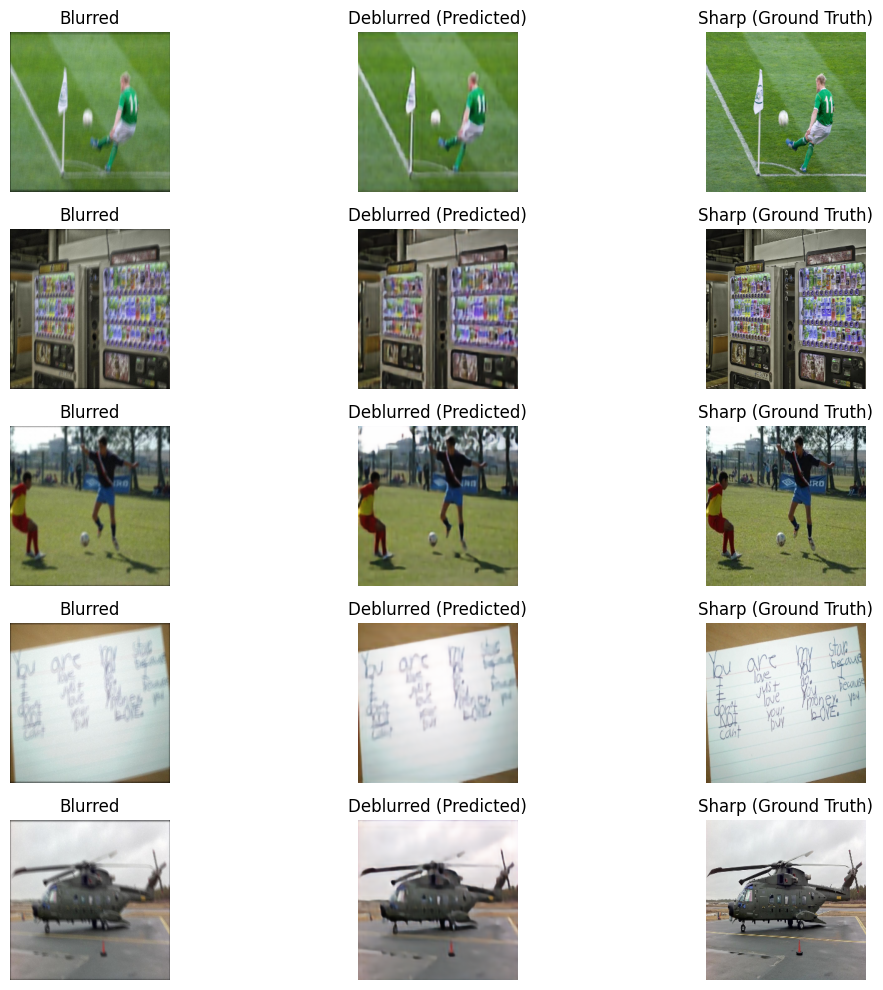

In [ ]:
# =====================[ 10. Visualisasi Hasil Prediksi ]=====================

# Ambil satu batch dari test set
test_blur_folder = os.path.join(dataset_path, 'test/blur')
test_sharp_folder = os.path.join(dataset_path, 'test/sharp')

sample_filenames = os.listdir(test_blur_folder)[:5]  # Ambil 5 gambar untuk demo

plt.figure(figsize=(12, 10))
for i, filename in enumerate(sample_filenames):
    blur_img = load_image(os.path.join(test_blur_folder, filename), image_size)
    sharp_img = load_image(os.path.join(test_sharp_folder, filename), image_size)

    # Model prediksi gambar blur → hasil deblur
    predicted = model.predict(np.expand_dims(blur_img, axis=0))[0]

    # Tampilkan: blur | predicted | sharp
    plt.subplot(len(sample_filenames), 3, i * 3 + 1)
    plt.imshow(blur_img)
    plt.title("Blurred")
    plt.axis('off')

    plt.subplot(len(sample_filenames), 3, i * 3 + 2)
    plt.imshow(predicted)
    plt.title("Deblurred (Predicted)")
    plt.axis('off')

    plt.subplot(len(sample_filenames), 3, i * 3 + 3)
    plt.imshow(sharp_img)
    plt.title("Sharp (Ground Truth)")
    plt.axis('off')

plt.tight_layout()
plt.show()
